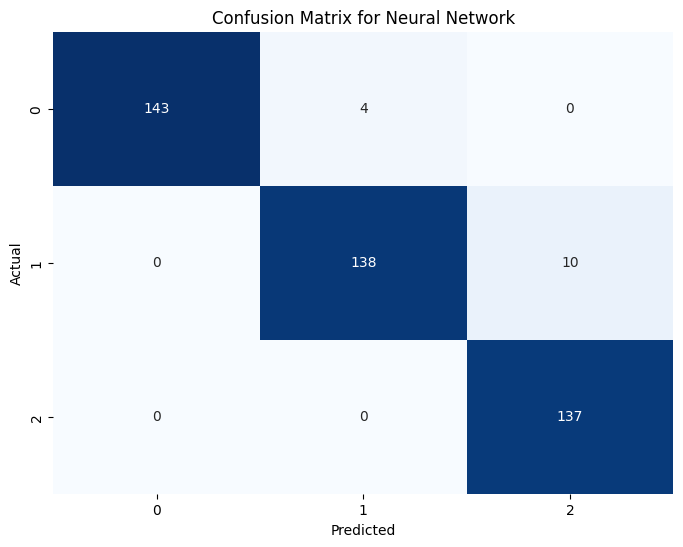

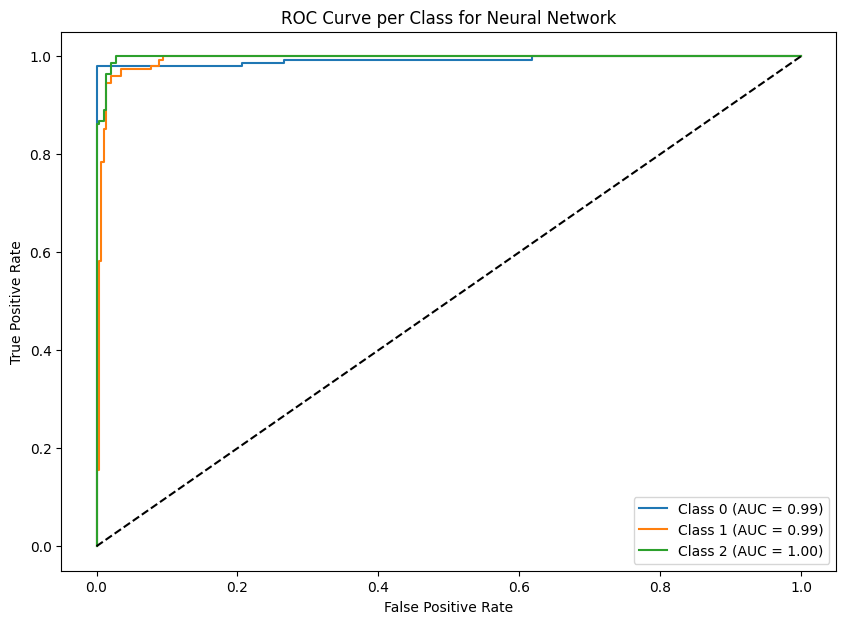

Results have been saved to 'model_evaluation_results_with_roc_conf_matrix.csv'.


In [ ]:
# Classification Model
# Necessary imports
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.auth import default
# Load Data
sheet_id = "18E65sMnhZd0r6M3rDr-Da8NGqQ9FhQV1"
sheet_name = "Sheet1"  # Change this if your sheet tab name is different

# Build CSV URL
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read into DataFrame
data = pd.read_csv(csv_url)


# Define features and target
feature_list = ['b* lab', 'log-Hue', 'log-Greeness']
X = data[feature_list]
y = data['Classification_label']

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Classifier configurations for GridSearchCV
param_grids = {
    # 'Logistic Regression': {
    #     'model': LogisticRegression(),
    #     'param_grid': {'C': [1], 'solver': ['liblinear']}
    # },
    # 'SVC': {
    #     'model': SVC(probability=True),
    #     'param_grid': {'C': [10], 'kernel': ['rbf']}
    # },
    # 'Decision Tree': {
    #     'model': DecisionTreeClassifier(),
    #     'param_grid': {'max_depth': [10], 'min_samples_split': [2]}
    # },
    'Neural Network': {
        'model': MLPClassifier(max_iter=3000, random_state=42),
        'param_grid': {'hidden_layer_sizes': [(50, 50)], 'activation': ['relu'], 'solver': ['adam']}
    }
}

# Store evaluation results
results = []

# Evaluate classifiers with hyperparameter tuning
for name, config in param_grids.items():
    model = config['model']
    param_grid = config['param_grid']

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    # Compute test accuracy and confusion matrix
    test_accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute precision, recall, and F1 scores
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)

    # Compute weighted scores
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_recall = recall_score(y_test, y_pred, average='weighted')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # Perform 10-fold cross-validation
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=10, scoring='accuracy')
    mean_cv_accuracy = cv_scores.mean()
    std_cv_accuracy = cv_scores.std()


    # Plot ROC Curve for each class
    if hasattr(best_model, "predict_proba"):  # Check if model supports probabilities
        y_test_binarized = label_binarize(y_test, classes=np.unique(y))
        y_score = best_model.predict_proba(X_test_scaled)

        plt.figure(figsize=(10, 7))
        for i, class_label in enumerate(np.unique(y)):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            auc_score = roc_auc_score(y_test_binarized[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc_score:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve per Class for {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

    # Append model results
    results.append({
        'Model': name,
        'Best Params': grid_search.best_params_,
        'Test Accuracy': test_accuracy,
        'Confusion Matrix': conf_matrix.tolist(),
        'Precision (per class)': precision_per_class.tolist(),
        'Recall (per class)': recall_per_class.tolist(),
        'F1 Score (per class)': f1_per_class.tolist(),
        'Weighted Precision': weighted_precision,
        'Weighted Recall': weighted_recall,
        'Weighted F1 Score': weighted_f1,
        'Mean CV Accuracy (10-fold)': mean_cv_accuracy,
        'Std CV Accuracy (10-fold)': std_cv_accuracy,

    })

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('model_evaluation_results_with_roc_conf_matrix.csv', index=False)
print("Results have been saved to 'model_evaluation_results_with_roc_conf_matrix.csv'.")


In [ ]:
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr, probplot
import time
import threading

# Build CSV URL
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

# Read into DataFrame
data = pd.read_csv(csv_url)


# Features and target variable
feature_list = ['b* lab', 'log-Hue', 'log-Greeness']
X = data[feature_list]
y = data['mg N/100g']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Neural Network': {
        'hidden_layer_sizes': [(50, 50)],
        'activation': ['tanh'],
        'solver': ['adam'],
        'alpha': [0.001],
        'learning_rate': ['constant'],
        'max_iter': [3000]
    },
    # 'SVR': {
    #     'kernel': ['rbf'],
    #     'C': [0.1, 1, 10, 100],
    #     'gamma': ['scale', 'auto']
    # },
    # 'Linear Regression': {},
}

# Models to tune
regressors = {
    'Neural Network': MLPRegressor(random_state=42, max_iter=3000),
    'SVR': SVR(),
    'Linear Regression': LinearRegression(),
}

# CPU protection settings
CPU_THRESHOLD = 85  # in percentage
CHECK_INTERVAL = 5  # in seconds


def monitor_cpu():
    """Monitor CPU usage and stop the process if it exceeds the threshold."""
    while True:
        cpu_usage = psutil.cpu_percent(interval=1)
        if cpu_usage > CPU_THRESHOLD:
            print(f"CPU usage {cpu_usage}% exceeded the threshold of {CPU_THRESHOLD}%")
            raise SystemExit("CPU usage too high. Terminating process to protect the system.")
        time.sleep(CHECK_INTERVAL)


# Start monitoring CPU usage in a separate thread
cpu_monitor_thread = threading.Thread(target=monitor_cpu)
cpu_monitor_thread.daemon = True  # Daemon thread will exit when the main program exits
cpu_monitor_thread.start()

# For saving results
results = []

# Load shelf life data
X_shelf_life = pd.read_excel('shelf_life_data_experimentalr.xlsx')
y_shelf_life = X_shelf_life['Experimental (N mg/100g)']

# Hyperparameter tuning using GridSearchCV
for name, model in regressors.items():
    if name in param_grids:  # Only do grid search if there is a parameter grid
        print(f"Performing Grid Search for {name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='r2', n_jobs=2)  # Limit to 2 cores
        grid_search.fit(X_train_scaled, y_train)

        # Get the best model and parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {name}: {best_params}")

        # Predict and evaluate the best model on test data
        y_pred = best_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmsep = np.sqrt(mse)  # RMSEP calculation
        r2 = r2_score(y_test, y_pred)

        # RMSECV calculation
        rmsecv_scores = -cross_val_score(best_model, X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
        rmsecv = np.sqrt(rmsecv_scores.mean())
        rmsecv_std = rmsecv_scores.std()

        # Cross-validated R²
        r2_cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=10, scoring='r2')
        r2_cv = r2_cv_scores.mean()
        r2_cv_std = r2_cv_scores.std()

        # Shelf life prediction
        X_shelf_scaled = scaler.transform(X_shelf_life[feature_list])
        y_shelf_pred = best_model.predict(X_shelf_scaled)
        print(y_shelf_pred)
        shelf_life_accuracy = r2_score(y_shelf_life, y_shelf_pred)
        mse_shelf = mean_squared_error(y_shelf_life, y_shelf_pred)
        rmsep_shelf = np.sqrt(mse_shelf)  # RMSEP calculation

        # Save the results for comparison
        results.append([feature_list, name, best_params, rmsep, rmsecv, rmsecv_std, r2, r2_cv, r2_cv_std, shelf_life_accuracy])

        print(f"Model: {name}, Test RMSEP: {rmsep:.4f}, Test RMSECV: {rmsecv:.4f} ± {rmsecv_std:.4f}, "
              f"Test R²: {r2:.4f}, Cross-validated R²: {r2_cv:.4f} ± {r2_cv_std:.4f}, Shelf Life R²: {shelf_life_accuracy:.4f},mse_shelf {mse_shelf}")

# Save results to CSV
results_df = pd.DataFrame(results, columns=['Features', 'Model', 'Best Params', 'RMSEP', 'RMSECV', 'RMSECV Std Dev', 'Test R²', 'Cross-validated R²', 'R² CV Std Dev', 'Shelf Life R²'])
results_df.to_csv('regression_model_results_with_tuning.csv', index=False)
print("Model evaluation results saved with hyperparameter tuning.")


Performing Grid Search for Neural Network...
CPU usage 99.5% exceeded the threshold of 85%
Best parameters for Neural Network: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 3000, 'solver': 'adam'}
Model: Neural Network, Test RMSEP: 2.2678, Test RMSECV: 2.2135 ± 1.8577, Test R²: 0.9138, Cross-validated R²: 0.9082 ± 0.0409,


ValueError: 10 columns passed, passed data had 9 columns

# New Section